# Assignment 3

Import required libraries

In [1]:
import torch
import random
import os
import numpy as np

In [58]:
# Set seeds for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

set_seed(42)

In [3]:
# Check for CUDA
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## Load and Prepare Data

In [4]:
import pandas
from torch.utils.data import Dataset, DataLoader

from dataset import TransliterationDataset, collate_fn

In [5]:
def prepare_data(dataset_path, batch_size=64, shuffle=True):
    dataset = TransliterationDataset(dataset_path)
    data_loader = DataLoader(
        dataset, 
        batch_size=batch_size, 
        shuffle=shuffle, 
        collate_fn=collate_fn
    )

    return dataset, data_loader

In [6]:
# Dataset paths
train_path = 'dakshina_dataset_v1.0/ml/lexicons/ml.translit.sampled.train.tsv'
val_path = 'dakshina_dataset_v1.0/ml/lexicons/ml.translit.sampled.dev.tsv'

# Create dataloaders
train_dataset, train_loader = prepare_data(train_path, batch_size=64)
val_dataset, val_loader = prepare_data(val_path, batch_size=64)

In [ ]:
# Model parameters
input_size = train_dataset.get_vocab_size('source')
output_size = train_dataset.get_vocab_size('target')


# Print vocabulary sizes
print(f"Source vocabulary size: {input_size}")
print(f"Target vocabulary size: {output_size}")

In [ ]:
# Model parameters
val_input_size = val_dataset.get_vocab_size('source')
val_output_size = val_dataset.get_vocab_size('target')

# Print vocabulary sizes
print(f"Validation - Source vocabulary size: {val_input_size}")
print(f"Validation - Target vocabulary size: {val_output_size}")

In [9]:
# Make sure val dataset uses the same vocabulary as training
val_dataset.source_char_to_idx = train_dataset.source_char_to_idx
val_dataset.source_idx_to_char = train_dataset.source_idx_to_char
val_dataset.target_char_to_idx = train_dataset.target_char_to_idx
val_dataset.target_idx_to_char = train_dataset.target_idx_to_char

## Train Model

In [6]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import trange

from vanilla_model import Encoder, Decoder, Seq2Seq
from training import train, evaluate, transliterate, calculate_accuracy

In [ ]:
def train_model(input_size, output_size, train_loader, val_loader, device, embedding_size=256, hidden_size=256, lr=0.001,
                n_layers=1, dropout=0.2, cell_type='lstm', epochs=10, teacher_forcing_ratio=0.5, clip=1.0, patience=5):  
    print(f"Using device: {device}")
    
    # Create model
    encoder = Encoder(
        input_size=input_size,
        embedding_size=embedding_size,
        hidden_size=hidden_size,
        n_layers=n_layers,
        dropout=dropout,
        cell_type=cell_type
    ).to(device)
    
    decoder = Decoder(
        output_size=output_size,
        embedding_size=embedding_size,
        hidden_size=hidden_size,
        n_layers=n_layers,
        dropout=dropout,
        cell_type=cell_type
    ).to(device)
    
    model = Seq2Seq(encoder, decoder, device).to(device)
    
    # Define optimizer and loss function
    optimizer = optim.Adam(model.parameters(), lr=lr)
    # # Define learning rate scheduler
    # scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)
    criterion = nn.CrossEntropyLoss(ignore_index=train_dataset.target_char_to_idx['<PAD>'])

    best_val_loss = float('inf')
    patience_counter = 0

    # Lists to store losses
    train_losses = []
    val_losses = []
    best_model = None

    # Training loop
    print("Starting training...")
    pbar = trange(epochs, desc="Epoch", dynamic_ncols=True)
    for epoch in pbar:
        # Train
        train_loss = train(
            model=model,
            device=device,
            dataloader=train_loader,
            optimizer=optimizer,
            criterion=criterion,
            clip=clip,
            teacher_forcing_ratio=teacher_forcing_ratio
        )
        train_losses.append(train_loss)
        
        # Validate
        val_loss = evaluate(
            model=model,
            device=device,
            dataloader=val_loader,
            criterion=criterion
        )
        val_losses.append(val_loss)

        # # Update learning rate based on validation loss
        # scheduler.step(val_loss)

        # Update tqdm bar description
        pbar.set_description(f"Epoch {epoch+1}/{epochs}")
        pbar.set_postfix(train_loss=f"{train_loss:.4f}", val_loss=f"{val_loss:.4f}")
            
        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = model
            torch.save(model.state_dict(), 'best_vanilla_model.pth')
        else:
            patience_counter += 1
            
        # Early stopping
        if patience_counter >= patience:
            print(f"Early stopping after {epoch+1} epochs!")
            break
    
    print("best model saved at: best_vanilla_model.pth")

    return train_losses, val_losses, best_model

In [ ]:
train_losses, val_losses, best_model = train_model(input_size=input_size, output_size=output_size, train_loader=train_loader, 
                                       val_loader=val_loader, device=device)

### Visualize training results

In [7]:
import matplotlib.pyplot as plt

In [ ]:
# Plot loss curves
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
# plt.savefig('loss_plot.png')

## Hyperparameter Tuning with Wandb

In [8]:
import wandb

In [9]:
BEST_VAL_LOSS = float('inf')
BEST_VAL_ACC = 0

In [10]:
# Train the model with wandb integration
def train_with_wandb(config=None):
    global BEST_VAL_LOSS, BEST_VAL_ACC
    
    # Initialize a new wandb run
    with wandb.init(config=config) as run:
        # If called by wandb.agent, use the config set by sweep controller
        config = wandb.config
        
        # Generate a descriptive name for the run based on key hyperparameters
        run_name = (
            f"ct{config.cell_type}-tfr{config.teacher_forcing_ratio}-lr{config.learning_rate}-es{config.embedding_size}-hs{config.hidden_size}-"
            f"nl{config.num_layers}-d{config.dropout}-bs{config.batch_size}"
        )
        
        run.name = run_name
        
        # Access hyperparameters as wandb.config
        config = wandb.config
        
        # Set seed
        set_seed(config.seed)
        
        # Device
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"Using device: {device}")
        
        # Create save directory if it doesn't exist
        if not os.path.exists('models'):
            os.makedirs('models')
        
        # Dataset paths
        train_path = 'dakshina_dataset_v1.0/ml/lexicons/ml.translit.sampled.train.tsv'
        val_path = 'dakshina_dataset_v1.0/ml/lexicons/ml.translit.sampled.dev.tsv'

        # Create dataloaders
        train_dataset, train_loader = prepare_data(train_path, batch_size=config.batch_size)
        val_dataset, val_loader = prepare_data(val_path, batch_size=config.batch_size)

        # Make sure val dataset uses the same vocabulary as training
        val_dataset.source_char_to_idx = train_dataset.source_char_to_idx
        val_dataset.source_idx_to_char = train_dataset.source_idx_to_char
        val_dataset.target_char_to_idx = train_dataset.target_char_to_idx
        val_dataset.target_idx_to_char = train_dataset.target_idx_to_char
        
        # Create model
        encoder = Encoder(
            input_size=train_dataset.get_vocab_size('source'),
            embedding_size=config.embedding_size,
            hidden_size=config.hidden_size,
            n_layers=config.num_layers,
            dropout=config.dropout,
            cell_type=config.cell_type
        )
        
        decoder = Decoder(
            output_size=train_dataset.get_vocab_size('target'),
            embedding_size=config.embedding_size,
            hidden_size=config.hidden_size,
            n_layers=config.num_layers,
            dropout=config.dropout,
            cell_type=config.cell_type
        )
        
        model = Seq2Seq(encoder, decoder, device).to(device)
        
        # Optimizer and criterion
        optimizer = optim.Adam(model.parameters(), lr=config.learning_rate)
        criterion = nn.CrossEntropyLoss(ignore_index=train_dataset.target_char_to_idx['<PAD>'])
        
        # Train model
        best_val_loss = float('inf')
        best_val_acc = 0
        patience = config.patience
        patience_counter = 0

        pbar = trange(int(config.epochs), desc="Epoch", dynamic_ncols=True)
        for epoch in pbar:
            # Train
            train_loss = train(
                model, device, train_loader, optimizer, criterion, 
                clip=config.clip, teacher_forcing_ratio=config.teacher_forcing_ratio
            )
            
            # Evaluate
            val_loss = evaluate(model, device, val_loader, criterion=criterion)

            # Evaluate accuracy on validation set
            correct = 0
            total = 0
            
            with torch.no_grad():
                for batch in val_loader:
                    source_texts = batch['source_text']
                    target_texts = batch['target_text']
                    
                    for i, source_text in enumerate(source_texts):
                        pred_text = transliterate(model, device, val_dataset, source_text)
                        
                        if pred_text == target_texts[i]:
                            correct += 1
                        total += 1
            
            val_acc = correct / total

            # Update tqdm bar description
            pbar.set_description(f"Epoch {epoch+1}/{config.epochs}")
            pbar.set_postfix(train_loss=f"{train_loss:.4f}", val_loss=f"{val_loss:.4f}", val_acc=f"{val_acc:.4f}")
            
            # Log to wandb
            wandb.log({
                'epoch': epoch + 1,
                'train_loss': train_loss,
                'val_loss': val_loss,
                'val_accuracy':val_acc
            })

            # Save best model based on validation loss
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_val_acc = val_acc
                model_path = os.path.join('models', f'model_{wandb.run.id}.pth')
                torch.save(model.state_dict(), model_path)

                if best_val_loss < BEST_VAL_LOSS:
                    BEST_VAL_LOSS = best_val_loss
                    BEST_VAL_ACC = best_val_acc
                    torch.save(model.state_dict(), "best_vanilla_model.pth")
                    
            else:
                patience_counter += 1
            
            # Early stopping
            if patience_counter >= patience:
                print(f"Early stopping after {epoch+1} epochs!")
                break

        # # Load best model for final evaluation
        # model.load_state_dict(torch.load(os.path.join('models', f'model_{wandb.run.id}.pth')))
        
        # # Evaluate accuracy on validation set
        # correct = 0
        # total = 0
        
        # with torch.no_grad():
        #     for batch in val_loader:
        #         source_texts = batch['source_text']
        #         target_texts = batch['target_text']
                
        #         for i, source_text in enumerate(source_texts):
        #             pred_text = transliterate(best_model, device, val_dataset, source_text)
                    
        #             if pred_text == target_texts[i]:
        #                 correct += 1
        #             total += 1
        
        # val_accuracy = correct / total
        # print(f'Validation Accuracy: {val_accuracy:.3f}')
        
        # print(f"\tBest model saved with val loss {best_val_loss:.3f} at model_{wandb.run.id}.pth")
        print(f"\tBest model saved with val acc {best_val_acc:.3f} at model_{wandb.run.id}.pth")

        # Log final metrics
        wandb.log({
            'best_val_loss': best_val_loss,
            'best_val_accuracy': best_val_acc
        })

In [11]:
# Define sweep configuration
sweep_config = {
    'method': 'bayes',
    'name': 'sweep_vanilla',
    'metric': {
        'name': 'val_loss',
        'goal': 'minimize'
    },
    'parameters': {
        'seed': {
            'value': 42
        },
        'learning_rate': {
           'min': 0.0001, 
           'max': 0.01
        },
        'batch_size': {
            'values': [32, 64]
        },
        'embedding_size': {
            'values': [64, 128, 256]
        },
        'hidden_size': {
            'values': [128, 256]
        },
        'num_layers': {
            'values': [1, 2]
        },
        'dropout': {
            'values': [0.1, 0.3]
        },
        'cell_type': {
            'values': ['rnn', 'lstm', 'gru']
        },
        'teacher_forcing_ratio': {
            'values': [0.5, 0.7]
        },
        'clip': {
            'value': 1.0
        },
        'epochs': {
            'value': 20
        },
        'patience': {
            'value': 5
        }
    }
}

In [12]:
os.environ["WANDB_NOTEBOOK_NAME"] = "vanilla.ipynb"

wandb.login()

wandb: Currently logged in as: ch21b021 (ch21b021-indian-institute-of-technology-madras) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [13]:
sweep_id = wandb.sweep(sweep_config, project='DA6401-Assignment-3')

# Run the sweep
wandb.agent(sweep_id, train_with_wandb, count=15)

Create sweep with ID: goazo3li
Sweep URL: https://wandb.ai/ch21b021-indian-institute-of-technology-madras/DA6401-Assignment-3/sweeps/goazo3li


wandb: Agent Starting Run: b0pab09l with config:
wandb: 	batch_size: 64
wandb: 	cell_type: gru
wandb: 	clip: 1
wandb: 	dropout: 0.3
wandb: 	embedding_size: 128
wandb: 	epochs: 20
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0008661112401271926
wandb: 	num_layers: 1
wandb: 	patience: 5
wandb: 	seed: 42
wandb: 	teacher_forcing_ratio: 0.5
d:\Anaconda\Lib\site-packages\pydantic\main.py:308: UserWarning: Pydantic serializer warnings:
  Expected `list[str]` but got `tuple` - serialized value may not be as expected
  Expected `list[str]` but got `tuple` - serialized value may not be as expected
  return self.__pydantic_serializer__.to_python(


Using device: cuda


Epoch 18/20:  85%|████████▌ | 17/20 [19:56<03:31, 70.39s/it, train_loss=0.4512, val_acc=0.3304, val_loss=1.1851]

Early stopping after 18 epochs!
	Best model saved with val acc 0.333 at model_b0pab09l.pth


best_val_accuracy,▁
best_val_loss,▁
epoch,▁▁▂▂▃▃▃▄▄▅▅▆▆▆▇▇██
train_loss,█▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁
val_accuracy,▁▃▄▅▆▆▇▇▇▇██▇█████
val_loss,█▅▄▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁
best_val_accuracy,0.33274
best_val_loss,1.16535
epoch,18
train_loss,0.45121
val_accuracy,0.33044


wandb: Agent Starting Run: wgyh9292 with config:
wandb: 	batch_size: 32
wandb: 	cell_type: rnn
wandb: 	clip: 1
wandb: 	dropout: 0.3
wandb: 	embedding_size: 128
wandb: 	epochs: 20
wandb: 	hidden_size: 256
wandb: 	learning_rate: 0.003188725147185221
wandb: 	num_layers: 2
wandb: 	patience: 5
wandb: 	seed: 42
wandb: 	teacher_forcing_ratio: 0.5
d:\Anaconda\Lib\site-packages\pydantic\main.py:308: UserWarning: Pydantic serializer warnings:
  Expected `list[str]` but got `tuple` - serialized value may not be as expected
  Expected `list[str]` but got `tuple` - serialized value may not be as expected
  return self.__pydantic_serializer__.to_python(


Using device: cuda


Epoch 8/20:  35%|███▌      | 7/20 [14:16<26:31, 122.43s/it, train_loss=2.7110, val_acc=0.0000, val_loss=3.2826]

Early stopping after 8 epochs!
	Best model saved with val acc 0.000 at model_wgyh9292.pth


best_val_accuracy,▁
best_val_loss,▁
epoch,▁▂▃▄▅▆▇█
train_loss,█▂▂▁▂▂▃▂
val_accuracy,▁▅▁▁█▁▁▁
val_loss,▅▂▁▆▂█▆▃
best_val_accuracy,0
best_val_loss,3.24454
epoch,8
train_loss,2.71098
val_accuracy,0


wandb: Agent Starting Run: varrx6m4 with config:
wandb: 	batch_size: 32
wandb: 	cell_type: lstm
wandb: 	clip: 1
wandb: 	dropout: 0.3
wandb: 	embedding_size: 256
wandb: 	epochs: 20
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.00835685822013963
wandb: 	num_layers: 1
wandb: 	patience: 5
wandb: 	seed: 42
wandb: 	teacher_forcing_ratio: 0.5
d:\Anaconda\Lib\site-packages\pydantic\main.py:308: UserWarning: Pydantic serializer warnings:
  Expected `list[str]` but got `tuple` - serialized value may not be as expected
  Expected `list[str]` but got `tuple` - serialized value may not be as expected
  return self.__pydantic_serializer__.to_python(


Using device: cuda


Epoch 13/20:  60%|██████    | 12/20 [21:59<14:39, 109.96s/it, train_loss=1.1815, val_acc=0.1083, val_loss=1.8149]

Early stopping after 13 epochs!
	Best model saved with val acc 0.105 at model_varrx6m4.pth


best_val_accuracy,▁
best_val_loss,▁
epoch,▁▂▂▃▃▄▅▅▆▆▇▇█
train_loss,█▄▃▂▂▂▁▁▁▁▁▁▁
val_accuracy,▁▃▄▅▆▆▆▇█▇███
val_loss,█▆▄▄▃▄▃▂▂▂▃▁▁
best_val_accuracy,0.10512
best_val_loss,1.80664
epoch,13
train_loss,1.18148
val_accuracy,0.10831


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 8v4ef2js with config:
wandb: 	batch_size: 32
wandb: 	cell_type: rnn
wandb: 	clip: 1
wandb: 	dropout: 0.1
wandb: 	embedding_size: 64
wandb: 	epochs: 20
wandb: 	hidden_size: 256
wandb: 	learning_rate: 0.005755694128839243
wandb: 	num_layers: 1
wandb: 	patience: 5
wandb: 	seed: 42
wandb: 	teacher_forcing_ratio: 0.7
d:\Anaconda\Lib\site-packages\pydantic\main.py:308: UserWarning: Pydantic serializer warnings:
  Expected `list[str]` but got `tuple` - serialized value may not be as expected
  Expected `list[str]` but got `tuple` - serialized value may not be as expected
  return self.__pydantic_serializer__.to_python(


Using device: cuda


Epoch 10/20:  45%|████▌     | 9/20 [17:18<21:09, 115.39s/it, train_loss=2.6513, val_acc=0.0000, val_loss=3.8258]

Early stopping after 10 epochs!
	Best model saved with val acc 0.000 at model_8v4ef2js.pth


best_val_accuracy,▁
best_val_loss,▁
epoch,▁▂▃▃▄▅▆▆▇█
train_loss,▅▁▂▄█▇▇▇██
val_accuracy,▁▁█▁▁▁▁▁▁▁
val_loss,▃▅▃▂█▃▃▁▁▄
best_val_accuracy,0
best_val_loss,3.71182
epoch,10
train_loss,2.65127
val_accuracy,0


wandb: Agent Starting Run: d6tbsrff with config:
wandb: 	batch_size: 64
wandb: 	cell_type: gru
wandb: 	clip: 1
wandb: 	dropout: 0.3
wandb: 	embedding_size: 256
wandb: 	epochs: 20
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0010425257331770335
wandb: 	num_layers: 1
wandb: 	patience: 5
wandb: 	seed: 42
wandb: 	teacher_forcing_ratio: 0.5
d:\Anaconda\Lib\site-packages\pydantic\main.py:308: UserWarning: Pydantic serializer warnings:
  Expected `list[str]` but got `tuple` - serialized value may not be as expected
  Expected `list[str]` but got `tuple` - serialized value may not be as expected
  return self.__pydantic_serializer__.to_python(


Using device: cuda


Epoch 17/20:  80%|████████  | 16/20 [18:47<04:41, 70.44s/it, train_loss=0.4846, val_acc=0.3007, val_loss=1.2601]

Early stopping after 17 epochs!
	Best model saved with val acc 0.311 at model_d6tbsrff.pth


best_val_accuracy,▁
best_val_loss,▁
epoch,▁▁▂▂▃▃▄▄▅▅▅▆▆▇▇██
train_loss,█▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁
val_accuracy,▁▃▄▅▆▆▆▇▇▇▇▇█████
val_loss,█▅▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁
best_val_accuracy,0.31094
best_val_loss,1.2098
epoch,17
train_loss,0.48459
val_accuracy,0.30066


wandb: Agent Starting Run: yov77fbe with config:
wandb: 	batch_size: 64
wandb: 	cell_type: gru
wandb: 	clip: 1
wandb: 	dropout: 0.3
wandb: 	embedding_size: 128
wandb: 	epochs: 20
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0040373669365282175
wandb: 	num_layers: 1
wandb: 	patience: 5
wandb: 	seed: 42
wandb: 	teacher_forcing_ratio: 0.5
d:\Anaconda\Lib\site-packages\pydantic\main.py:308: UserWarning: Pydantic serializer warnings:
  Expected `list[str]` but got `tuple` - serialized value may not be as expected
  Expected `list[str]` but got `tuple` - serialized value may not be as expected
  return self.__pydantic_serializer__.to_python(


Using device: cuda


Epoch 15/20:  70%|███████   | 14/20 [16:19<06:59, 69.98s/it, train_loss=0.5664, val_acc=0.2684, val_loss=1.3208]

Early stopping after 15 epochs!
	Best model saved with val acc 0.273 at model_yov77fbe.pth


best_val_accuracy,▁
best_val_loss,▁
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_loss,█▄▃▃▂▂▂▂▁▁▁▁▁▁▁
val_accuracy,▁▄▅▆▆▇▇▇▇▇▇███▇
val_loss,█▅▃▂▃▂▂▂▂▂▁▁▁▁▂
best_val_accuracy,0.273
best_val_loss,1.26631
epoch,15
train_loss,0.56637
val_accuracy,0.26839


wandb: Agent Starting Run: rp21mtpq with config:
wandb: 	batch_size: 64
wandb: 	cell_type: gru
wandb: 	clip: 1
wandb: 	dropout: 0.3
wandb: 	embedding_size: 256
wandb: 	epochs: 20
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0009153932521338548
wandb: 	num_layers: 1
wandb: 	patience: 5
wandb: 	seed: 42
wandb: 	teacher_forcing_ratio: 0.5
d:\Anaconda\Lib\site-packages\pydantic\main.py:308: UserWarning: Pydantic serializer warnings:
  Expected `list[str]` but got `tuple` - serialized value may not be as expected
  Expected `list[str]` but got `tuple` - serialized value may not be as expected
  return self.__pydantic_serializer__.to_python(


Using device: cuda


Epoch 17/20:  80%|████████  | 16/20 [18:36<04:39, 69.78s/it, train_loss=0.4852, val_acc=0.3093, val_loss=1.2411]

Early stopping after 17 epochs!
	Best model saved with val acc 0.308 at model_rp21mtpq.pth


best_val_accuracy,▁
best_val_loss,▁
epoch,▁▁▂▂▃▃▄▄▅▅▅▆▆▇▇██
train_loss,█▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁
val_accuracy,▁▃▄▅▆▆▇▇▇▇█▇█████
val_loss,█▅▄▃▃▂▁▂▁▁▁▁▁▁▁▁▁
best_val_accuracy,0.30792
best_val_loss,1.23816
epoch,17
train_loss,0.48521
val_accuracy,0.30934


wandb: Agent Starting Run: o0eocgra with config:
wandb: 	batch_size: 64
wandb: 	cell_type: gru
wandb: 	clip: 1
wandb: 	dropout: 0.3
wandb: 	embedding_size: 256
wandb: 	epochs: 20
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0019665897671907132
wandb: 	num_layers: 1
wandb: 	patience: 5
wandb: 	seed: 42
wandb: 	teacher_forcing_ratio: 0.5
d:\Anaconda\Lib\site-packages\pydantic\main.py:308: UserWarning: Pydantic serializer warnings:
  Expected `list[str]` but got `tuple` - serialized value may not be as expected
  Expected `list[str]` but got `tuple` - serialized value may not be as expected
  return self.__pydantic_serializer__.to_python(


Using device: cuda


Epoch 13/20:  60%|██████    | 12/20 [14:41<09:47, 73.47s/it, train_loss=0.5621, val_acc=0.2711, val_loss=1.3244]

Early stopping after 13 epochs!
	Best model saved with val acc 0.267 at model_o0eocgra.pth


best_val_accuracy,▁
best_val_loss,▁
epoch,▁▂▂▃▃▄▅▅▆▆▇▇█
train_loss,█▄▃▃▂▂▂▂▁▁▁▁▁
val_accuracy,▁▃▅▅▆▆▇▇█▇███
val_loss,█▆▄▃▄▂▂▂▁▂▁▁▁
best_val_accuracy,0.26733
best_val_loss,1.3038
epoch,13
train_loss,0.56208
val_accuracy,0.27105


wandb: Agent Starting Run: ddy5e93g with config:
wandb: 	batch_size: 64
wandb: 	cell_type: gru
wandb: 	clip: 1
wandb: 	dropout: 0.3
wandb: 	embedding_size: 256
wandb: 	epochs: 20
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0008502742453661464
wandb: 	num_layers: 1
wandb: 	patience: 5
wandb: 	seed: 42
wandb: 	teacher_forcing_ratio: 0.7
d:\Anaconda\Lib\site-packages\pydantic\main.py:308: UserWarning: Pydantic serializer warnings:
  Expected `list[str]` but got `tuple` - serialized value may not be as expected
  Expected `list[str]` but got `tuple` - serialized value may not be as expected
  return self.__pydantic_serializer__.to_python(


Using device: cuda


Epoch 13/20:  60%|██████    | 12/20 [15:18<10:12, 76.54s/it, train_loss=0.4496, val_acc=0.3058, val_loss=1.4973]

Early stopping after 13 epochs!
	Best model saved with val acc 0.307 at model_ddy5e93g.pth


best_val_accuracy,▁
best_val_loss,▁
epoch,▁▂▂▃▃▄▅▅▆▆▇▇█
train_loss,█▄▃▃▂▂▂▂▁▁▁▁▁
val_accuracy,▁▃▄▆▆▆▇▇▇▇███
val_loss,█▅▃▃▃▂▂▂▁▂▂▁▁
best_val_accuracy,0.30686
best_val_loss,1.44959
epoch,13
train_loss,0.44965
val_accuracy,0.3058


wandb: Agent Starting Run: t6e1jybw with config:
wandb: 	batch_size: 64
wandb: 	cell_type: gru
wandb: 	clip: 1
wandb: 	dropout: 0.3
wandb: 	embedding_size: 256
wandb: 	epochs: 20
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.004677245912475413
wandb: 	num_layers: 1
wandb: 	patience: 5
wandb: 	seed: 42
wandb: 	teacher_forcing_ratio: 0.5
d:\Anaconda\Lib\site-packages\pydantic\main.py:308: UserWarning: Pydantic serializer warnings:
  Expected `list[str]` but got `tuple` - serialized value may not be as expected
  Expected `list[str]` but got `tuple` - serialized value may not be as expected
  return self.__pydantic_serializer__.to_python(


Using device: cuda


Epoch 15/20:  70%|███████   | 14/20 [16:39<07:08, 71.40s/it, train_loss=0.8083, val_acc=0.1861, val_loss=1.5659]

Early stopping after 15 epochs!
	Best model saved with val acc 0.185 at model_t6e1jybw.pth


best_val_accuracy,▁
best_val_loss,▁
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_loss,█▄▃▃▂▂▂▂▂▁▁▁▁▁▁
val_accuracy,▁▃▅▅▆▆▇█▇██████
val_loss,█▆▄▄▄▃▃▂▂▁▁▁▂▁▂
best_val_accuracy,0.18472
best_val_loss,1.53117
epoch,15
train_loss,0.80833
val_accuracy,0.18614


wandb: Agent Starting Run: t12qt17c with config:
wandb: 	batch_size: 64
wandb: 	cell_type: gru
wandb: 	clip: 1
wandb: 	dropout: 0.3
wandb: 	embedding_size: 128
wandb: 	epochs: 20
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.00080662118079231
wandb: 	num_layers: 1
wandb: 	patience: 5
wandb: 	seed: 42
wandb: 	teacher_forcing_ratio: 0.5
d:\Anaconda\Lib\site-packages\pydantic\main.py:308: UserWarning: Pydantic serializer warnings:
  Expected `list[str]` but got `tuple` - serialized value may not be as expected
  Expected `list[str]` but got `tuple` - serialized value may not be as expected
  return self.__pydantic_serializer__.to_python(


Using device: cuda


Epoch 16/20:  75%|███████▌  | 15/20 [19:21<06:27, 77.44s/it, train_loss=0.4765, val_acc=0.3246, val_loss=1.1913]

Early stopping after 16 epochs!
	Best model saved with val acc 0.327 at model_t12qt17c.pth


best_val_accuracy,▁
best_val_loss,▁
epoch,▁▁▂▂▃▃▄▄▅▅▆▆▇▇██
train_loss,█▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁
val_accuracy,▁▃▄▅▆▆▇▇▇▇▇▇████
val_loss,█▅▄▃▃▂▂▂▂▂▁▂▂▁▁▁
best_val_accuracy,0.32654
best_val_loss,1.15021
epoch,16
train_loss,0.47652
val_accuracy,0.32459


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 7xumr5o5 with config:
wandb: 	batch_size: 64
wandb: 	cell_type: gru
wandb: 	clip: 1
wandb: 	dropout: 0.3
wandb: 	embedding_size: 256
wandb: 	epochs: 20
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0010943557294746198
wandb: 	num_layers: 1
wandb: 	patience: 5
wandb: 	seed: 42
wandb: 	teacher_forcing_ratio: 0.5
d:\Anaconda\Lib\site-packages\pydantic\main.py:308: UserWarning: Pydantic serializer warnings:
  Expected `list[str]` but got `tuple` - serialized value may not be as expected
  Expected `list[str]` but got `tuple` - serialized value may not be as expected
  return self.__pydantic_serializer__.to_python(


Using device: cuda


Epoch 18/20:  85%|████████▌ | 17/20 [21:19<03:45, 75.26s/it, train_loss=0.4735, val_acc=0.2960, val_loss=1.2904]

Early stopping after 18 epochs!
	Best model saved with val acc 0.294 at model_7xumr5o5.pth


best_val_accuracy,▁
best_val_loss,▁
epoch,▁▁▂▂▃▃▃▄▄▅▅▆▆▆▇▇██
train_loss,█▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁
val_accuracy,▁▃▄▅▆▆▆▇▇▇████████
val_loss,█▅▄▃▂▂▂▂▂▂▁▁▁▁▁▁▂▁
best_val_accuracy,0.2941
best_val_loss,1.24886
epoch,18
train_loss,0.47353
val_accuracy,0.29605


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: gxr2uo6q with config:
wandb: 	batch_size: 64
wandb: 	cell_type: gru
wandb: 	clip: 1
wandb: 	dropout: 0.3
wandb: 	embedding_size: 256
wandb: 	epochs: 20
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.004108875385328682
wandb: 	num_layers: 1
wandb: 	patience: 5
wandb: 	seed: 42
wandb: 	teacher_forcing_ratio: 0.5
d:\Anaconda\Lib\site-packages\pydantic\main.py:308: UserWarning: Pydantic serializer warnings:
  Expected `list[str]` but got `tuple` - serialized value may not be as expected
  Expected `list[str]` but got `tuple` - serialized value may not be as expected
  return self.__pydantic_serializer__.to_python(


Using device: cuda


Epoch 17/20:  80%|████████  | 16/20 [20:51<05:12, 78.22s/it, train_loss=0.7244, val_acc=0.2237, val_loss=1.4798]

Early stopping after 17 epochs!
	Best model saved with val acc 0.217 at model_gxr2uo6q.pth


best_val_accuracy,▁
best_val_loss,▁
epoch,▁▁▂▂▃▃▄▄▅▅▅▆▆▇▇██
train_loss,█▄▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁
val_accuracy,▁▃▄▅▆▆▆▇▇▇▇█▇████
val_loss,█▅▄▄▃▃▃▃▂▁▁▁▁▁▁▁▁
best_val_accuracy,0.21734
best_val_loss,1.46608
epoch,17
train_loss,0.72436
val_accuracy,0.22372


wandb: Agent Starting Run: arah4s8c with config:
wandb: 	batch_size: 64
wandb: 	cell_type: gru
wandb: 	clip: 1
wandb: 	dropout: 0.3
wandb: 	embedding_size: 128
wandb: 	epochs: 20
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.002582458384243965
wandb: 	num_layers: 2
wandb: 	patience: 5
wandb: 	seed: 42
wandb: 	teacher_forcing_ratio: 0.5
d:\Anaconda\Lib\site-packages\pydantic\main.py:308: UserWarning: Pydantic serializer warnings:
  Expected `list[str]` but got `tuple` - serialized value may not be as expected
  Expected `list[str]` but got `tuple` - serialized value may not be as expected
  return self.__pydantic_serializer__.to_python(


Using device: cuda


Epoch 12/20:  55%|█████▌    | 11/20 [16:46<13:43, 91.49s/it, train_loss=0.5524, val_acc=0.3207, val_loss=1.1998]

Early stopping after 12 epochs!
	Best model saved with val acc 0.326 at model_arah4s8c.pth


best_val_accuracy,▁
best_val_loss,▁
epoch,▁▂▂▃▄▄▅▅▆▇▇█
train_loss,█▄▃▂▂▂▁▁▁▁▁▁
val_accuracy,▁▄▅▆▇▇▇▇████
val_loss,█▄▄▂▃▁▁▃▁▁▁▂
best_val_accuracy,0.32601
best_val_loss,1.16229
epoch,12
train_loss,0.55244
val_accuracy,0.32069


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: sufjutft with config:
wandb: 	batch_size: 64
wandb: 	cell_type: gru
wandb: 	clip: 1
wandb: 	dropout: 0.3
wandb: 	embedding_size: 128
wandb: 	epochs: 20
wandb: 	hidden_size: 256
wandb: 	learning_rate: 0.004918313031676984
wandb: 	num_layers: 2
wandb: 	patience: 5
wandb: 	seed: 42
wandb: 	teacher_forcing_ratio: 0.7
d:\Anaconda\Lib\site-packages\pydantic\main.py:308: UserWarning: Pydantic serializer warnings:
  Expected `list[str]` but got `tuple` - serialized value may not be as expected
  Expected `list[str]` but got `tuple` - serialized value may not be as expected
  return self.__pydantic_serializer__.to_python(


Using device: cuda


Epoch 8/20:  35%|███▌      | 7/20 [11:56<22:10, 102.35s/it, train_loss=0.8939, val_acc=0.1822, val_loss=1.7384]

Early stopping after 8 epochs!
	Best model saved with val acc 0.182 at model_sufjutft.pth


best_val_accuracy,▁
best_val_loss,▁
epoch,▁▂▃▄▅▆▇█
train_loss,█▁▁▁▁▁▂▁
val_accuracy,▃▁█▆▅▅▅▆
val_loss,▆█▄▁█▄▂▂
best_val_accuracy,0.18206
best_val_loss,1.71876
epoch,8
train_loss,0.89385
val_accuracy,0.18224


# Model Inference

In [ ]:
def analyze_errors(predictions):
    """
    Analyze the errors made by the model
    """
    # Analyze error patterns
    errors = [(source, pred, target) for source, pred, target in predictions if pred != target]
    
    # # Error by length
    # length_errors = {}
    # for source, _, target in errors:
    #     length = len(source)
    #     if length not in length_errors:
    #         length_errors[length] = 0
    #     length_errors[length] += 1
    
    # # Sort by length
    # sorted_length_errors = {k: v for k, v in sorted(length_errors.items())}
    
    # plt.figure(figsize=(10, 6))
    # plt.bar(sorted_length_errors.keys(), sorted_length_errors.values())
    # plt.xlabel('Source Length')
    # plt.ylabel('Number of Errors')
    # plt.title('Errors by Source Length')
    # plt.savefig('predictions_vanilla/errors_by_length.png')
    
    # Sample error analysis
    print("\nSample Error Analysis:")
    for i, (source, pred, target) in enumerate(errors[:10]):
        print(f'Source: {source}')
        print(f'Prediction: {pred}')
        print(f'Target: {target}')
        print()

In [26]:
def test_model(config, model_path):
    # Load datasets
    train_dataset_path = "dakshina_dataset_v1.0/ml/lexicons/ml.translit.sampled.train.tsv"
    test_dataset_path = "dakshina_dataset_v1.0/ml/lexicons/ml.translit.sampled.test.tsv"
    
    train_dataset, _ = prepare_data(train_dataset_path, batch_size=config['batch_size'], shuffle=False)
    test_dataset, test_dataloader = prepare_data(test_dataset_path, batch_size=config['batch_size'], shuffle=False)
    
    # Make sure test dataset uses the same vocabulary as training
    test_dataset.source_char_to_idx = train_dataset.source_char_to_idx
    test_dataset.source_idx_to_char = train_dataset.source_idx_to_char
    test_dataset.target_char_to_idx = train_dataset.target_char_to_idx
    test_dataset.target_idx_to_char = train_dataset.target_idx_to_char

    # Initialize model with best configuration
    input_size = train_dataset.get_vocab_size('source')
    output_size = train_dataset.get_vocab_size('target')
        
    # Device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")    

    encoder = Encoder(
        input_size=input_size, 
        embedding_size=config['embedding_size'], 
        hidden_size=config['hidden_size'], 
        n_layers=config['num_layers'], 
        dropout=config['dropout'],
        cell_type=config['cell_type']
    )
    
    decoder = Decoder(
        output_size=output_size, 
        embedding_size=config['embedding_size'], 
        hidden_size=config['hidden_size'], 
        n_layers=config['num_layers'], 
        dropout=config['dropout'],
        cell_type=config['cell_type']
    )
    
    model = Seq2Seq(encoder, decoder, device).to(device)
    
    # Load model parameters
    model.load_state_dict(torch.load(model_path))
    
    # Evaluate on test set
    test_accuracy, test_predictions = calculate_accuracy(model, device, test_dataloader, test_dataset)
    
    print(f'Test Accuracy: {test_accuracy:.3f}')
    
    # Save predictions to file
    with open('predictions_vanilla/test_predictions.txt', 'w', encoding='utf-8') as f:
        for source, pred, target in test_predictions:
            f.write(f'Source: {source}\n')
            f.write(f'Prediction: {pred}\n')
            f.write(f'Target: {target}\n\n')
    
    analyze_errors(test_predictions)

    return test_accuracy, test_predictions

In [77]:
import matplotlib.font_manager as fm
import math
import pandas as pd

In [96]:
# Path to a font that supports Malayalam
MALAYALAM_FONT_PATH = "D:/Ayaan/IITM/Courses/Sem 8/DA6401/Noto_Sans_Malayalam/Noto_Sans_Malayalam/NotoSansMalayalam-VariableFont_wdth,wght.ttf"

In [81]:
def visualize_predictions(predictions, num_correct=5, num_incorrect=5):
    global MALAYALAM_FONT_PATH
    
    # Separate correct and incorrect predictions
    correct_preds = [(src, pred, tgt) for src, pred, tgt in predictions if pred == tgt]
    incorrect_preds = [(src, pred, tgt) for src, pred, tgt in predictions if pred != tgt]
    
    random.seed(42)

    # Sample predictions
    sample_correct = random.sample(correct_preds, min(num_correct, len(correct_preds)))
    sample_incorrect = random.sample(incorrect_preds, min(num_incorrect, len(incorrect_preds)))
    samples = sample_correct + sample_incorrect
    
    total_samples = len(samples)
    ncols = 5
    nrows = math.ceil(total_samples / ncols)
    
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, nrows * 1.5))
    axes = axes.flatten() if total_samples > 1 else [axes]

    # Load and set Malayalam font if available
    if os.path.exists(MALAYALAM_FONT_PATH):
        font_prop = fm.FontProperties(fname=MALAYALAM_FONT_PATH)
    else:
        font_prop = None

    for i, ax in enumerate(axes):
        ax.axis('off')
        if i >= total_samples:
            continue
        
        src, pred, tgt = samples[i]
        is_correct = pred == tgt
        color = 'green' if is_correct else 'red'

        # Compose text
        text = f"Input: {src}\nPrediction: {pred}\nTarget: {tgt}"

        # Add text with optional font
        ax.text(0.01, 0.5, text, fontsize=12, color=color, va='center', ha='left',
                fontproperties=font_prop, wrap=True)

    plt.tight_layout()
    plt.show()

    # Create a DataFrame
    df = pd.DataFrame(samples, columns=["Input", "Prediction", "Target"])
    df["Correct"] = df["Prediction"] == df["Target"]
    df["Status"] = df["Correct"].map({True: "Correct", False: "False"})
    df.drop('Correct', axis=1, inplace=True)

    return fig, df

In [88]:
from collections import Counter, defaultdict
import seaborn as sns
import pandas as pd
import matplotlib as mpl

In [101]:
# Create confusion matrix for the most common errors
def create_character_confusion_matrix(predictions, top_n=10):
    """
    Create a confusion matrix for top N most confused characters
    Args:
        predictions: List of (source, prediction, target) tuples
        top_n: Number of top confused character pairs to show
    
    Returns:
        fig: Confusion matrix figure
    """
    # Character level confusion counts
    char_confusions = defaultdict(Counter)
    
    for _, pred, target in predictions:
        if pred == target:
            continue  # Skip correct predictions
        
        # Use dynamic programming to find the minimum edit distance and alignment
        m, n = len(pred), len(target)
        dp = [[0] * (n + 1) for _ in range(m + 1)]
        
        # Initialize dp matrix
        for i in range(m + 1):
            dp[i][0] = i
        for j in range(n + 1):
            dp[0][j] = j
        
        # Fill dp matrix
        for i in range(1, m + 1):
            for j in range(1, n + 1):
                if pred[i-1] == target[j-1]:
                    dp[i][j] = dp[i-1][j-1]
                else:
                    dp[i][j] = 1 + min(dp[i-1][j],      # deletion
                                       dp[i][j-1],      # insertion
                                       dp[i-1][j-1])    # substitution
        
        # Backtrack to find alignment
        i, j = m, n
        while i > 0 and j > 0:
            if pred[i-1] == target[j-1]:
                i -= 1
                j -= 1
            else:
                min_op = min(dp[i-1][j], dp[i][j-1], dp[i-1][j-1])
                if dp[i-1][j-1] == min_op:  # substitution
                    char_confusions[target[j-1]][pred[i-1]] += 1
                    i -= 1
                    j -= 1
                elif dp[i-1][j] == min_op:  # deletion
                    char_confusions[target[j-1]]['_DEL_'] += 1
                    i -= 1
                else:  # insertion
                    char_confusions['_INS_'][pred[i-1]] += 1
                    j -= 1
    
    # Find the most confused characters
    all_confusions = []
    for true_char, pred_counts in char_confusions.items():
        for pred_char, count in pred_counts.items():
            all_confusions.append((true_char, pred_char, count))
    
    # Sort by count in descending order
    all_confusions.sort(key=lambda x: x[2], reverse=True)
    
    # Take top N
    top_confusions = all_confusions[:top_n]
    
    # Create confusion matrix dataframe
    true_chars = [t for t, _, _ in top_confusions]
    pred_chars = [p for _, p, _ in top_confusions]
    
    unique_chars = sorted(set(true_chars + pred_chars))
    conf_matrix = pd.DataFrame(0, index=unique_chars, columns=unique_chars)
    
    for true_char, pred_char, count in top_confusions:
        conf_matrix.loc[true_char, pred_char] = count
    
    # Load and set Malayalam font if available
    if os.path.exists(MALAYALAM_FONT_PATH):
        font_prop = fm.FontProperties(fname=MALAYALAM_FONT_PATH)
        fontname = font_prop.get_name()

        # Set global font
        mpl.rcParams['font.family'] = fontname
    else:
        font_prop = None
    
    # Plot
    plt.figure(figsize=(12, 10))
    ax = sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
                     cbar=False, linewidths=0.5, linecolor='gray',
                     annot_kws={'fontproperties': font_prop} if font_prop else None)

    ax.set_title(f'Top {top_n} Character Confusion Pairs', fontsize=16, fontproperties=font_prop)
    ax.set_xlabel('Predicted Character', fontsize=14, fontproperties=font_prop)
    ax.set_ylabel('True Character', fontsize=14, fontproperties=font_prop)

    # Update tick labels font
    for label in ax.get_xticklabels():
        label.set_fontproperties(font_prop)
    for label in ax.get_yticklabels():
        label.set_fontproperties(font_prop)

    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    # Convert to dataframe
    df = pd.DataFrame(top_confusions, columns=["True Character", "Predicted Character", "Count"])

    return plt, df

In [ ]:
# Create a directory for predictions if it doesn't exist
if not os.path.exists('predictions_vanilla'):
    os.makedirs('predictions_vanilla')

In [ ]:
best_config = {'embedding_size': 128, 'hidden_size': 128, 'num_layers': 1, 'dropout': 0.3, 'cell_type': "gru", 'batch_size': 64}
best_model_path = "models/model_b0pab09l.pth"

test_accuracy, predictions = test_model(config=best_config, model_path=best_model_path)

In [ ]:
# Create a more creative visualization with color coding
pred_fig, pred_df = visualize_predictions(predictions)

pred_df

In [ ]:
# Analyze the most common errors
conf_fig, conf_df = create_character_confusion_matrix(predictions, top_n=20)

conf_df

In [ ]:
def test_with_wandb(run_name, config, model_path):
    # Initialize wandb
    wandb.init(project="DA6401-Assignment-3", name=run_name, tags=["test", "vanilla", "evaluation"])
    
    test_accuracy, predictions = test_model(config=config, model_path=model_path)
    # Log to wandb
    wandb.log({"test_accuracy": test_accuracy})

    pred_fig, pred_df = visualize_predictions(predictions)
    pred_table = wandb.Table(dataframe=pred_df)
    # Log to wandb
    wandb.log({"sample_predictions_table": pred_table})
    wandb.log({"sample_predictions": wandb.Image(pred_fig)})
    
    conf_mat, conf_df = create_character_confusion_matrix(predictions)
    # Log to wandb
    wandb.log({"character_confusions_table": wandb.Image(conf_mat)})
    conf_table = wandb.Table(dataframe=conf_df)
    wandb.log({"character_confusions": conf_table})

test_accuracy,▁
test_accuracy,0.31979


d:\Anaconda\Lib\site-packages\pydantic\main.py:308: UserWarning: Pydantic serializer warnings:
  Expected `list[str]` but got `tuple` - serialized value may not be as expected
  Expected `list[str]` but got `tuple` - serialized value may not be as expected
  return self.__pydantic_serializer__.to_python(


Using device: cuda


findfont: Font family 'Noto Sans Malayalam' not found.
findfont: Font family 'Noto Sans Malayalam' not found.
findfont: Font family 'Noto Sans Malayalam' not found.
findfont: Font family 'Noto Sans Malayalam' not found.
findfont: Font family 'Noto Sans Malayalam' not found.
findfont: Font family 'Noto Sans Malayalam' not found.
findfont: Font family 'Noto Sans Malayalam' not found.
findfont: Font family 'Noto Sans Malayalam' not found.
findfont: Font family 'Noto Sans Malayalam' not found.
findfont: Font family 'Noto Sans Malayalam' not found.
findfont: Font family 'Noto Sans Malayalam' not found.
findfont: Font family 'Noto Sans Malayalam' not found.
findfont: Font family 'Noto Sans Malayalam' not found.
findfont: Font family 'Noto Sans Malayalam' not found.
findfont: Font family 'Noto Sans Malayalam' not found.
findfont: Font family 'Noto Sans Malayalam' not found.
findfont: Font family 'Noto Sans Malayalam' not found.
findfont: Font family 'Noto Sans Malayalam' not found.
findfont: 

Test Accuracy: 0.320


findfont: Font family 'Noto Sans Malayalam' not found.
findfont: Font family 'Noto Sans Malayalam' not found.
findfont: Font family 'Noto Sans Malayalam' not found.
findfont: Font family 'Noto Sans Malayalam' not found.
findfont: Font family 'Noto Sans Malayalam' not found.
findfont: Font family 'Noto Sans Malayalam' not found.
findfont: Font family 'Noto Sans Malayalam' not found.
findfont: Font family 'Noto Sans Malayalam' not found.
findfont: Font family 'Noto Sans Malayalam' not found.
findfont: Font family 'Noto Sans Malayalam' not found.
findfont: Font family 'Noto Sans Malayalam' not found.
findfont: Font family 'Noto Sans Malayalam' not found.
findfont: Font family 'Noto Sans Malayalam' not found.
findfont: Font family 'Noto Sans Malayalam' not found.
findfont: Font family 'Noto Sans Malayalam' not found.
findfont: Font family 'Noto Sans Malayalam' not found.



Sample Error Analysis:
Source: adisthaanamaakkiyaanu
Prediction: അടിസ്ഥാനമാക്കായാണ്
Target: അടിസ്ഥാനമാക്കിയാണ്

Source: atisthaanamaakkiyaanu
Prediction: അടിസ്ഥാനമാക്കായാണ്
Target: അടിസ്ഥാനമാക്കിയാണ്

Source: adisthaanamaakkiya
Prediction: അടിസ്ഥാനമാക്കായി
Target: അടിസ്ഥാനമാക്കിയ

Source: adayaalamaayi
Prediction: അടയലമായി
Target: അടയാളമായി

Source: atayaalamaayi
Prediction: അടയലമായി
Target: അടയാളമായി

Source: angathwavum
Prediction: അഗ്വത്വവും
Target: അംഗത്വവും

Source: ambaassador
Prediction: അമ്സാസർ
Target: അംബാസഡർ

Source: accountukal
Prediction: അക്കോട്ടുകൾ
Target: അക്കൗണ്ടുകൾ

Source: akksundukal
Prediction: അക്കുടുക്കൽ
Target: അക്കൗണ്ടുകൾ

Source: adayalamayi
Prediction: അടലയമായി
Target: അടയാളമായി



findfont: Font family 'Noto Sans Malayalam' not found.
findfont: Font family 'Noto Sans Malayalam' not found.
findfont: Font family 'Noto Sans Malayalam' not found.
findfont: Font family 'Noto Sans Malayalam' not found.
findfont: Font family 'Noto Sans Malayalam' not found.
findfont: Font family 'Noto Sans Malayalam' not found.
findfont: Font family 'Noto Sans Malayalam' not found.
findfont: Font family 'Noto Sans Malayalam' not found.
findfont: Font family 'Noto Sans Malayalam' not found.
findfont: Font family 'Noto Sans Malayalam' not found.
findfont: Font family 'Noto Sans Malayalam' not found.
findfont: Font family 'Noto Sans Malayalam' not found.
findfont: Font family 'Noto Sans Malayalam' not found.
findfont: Font family 'Noto Sans Malayalam' not found.
findfont: Font family 'Noto Sans Malayalam' not found.
findfont: Font family 'Noto Sans Malayalam' not found.
findfont: Font family 'Noto Sans Malayalam' not found.
findfont: Font family 'Noto Sans Malayalam' not found.
findfont: 

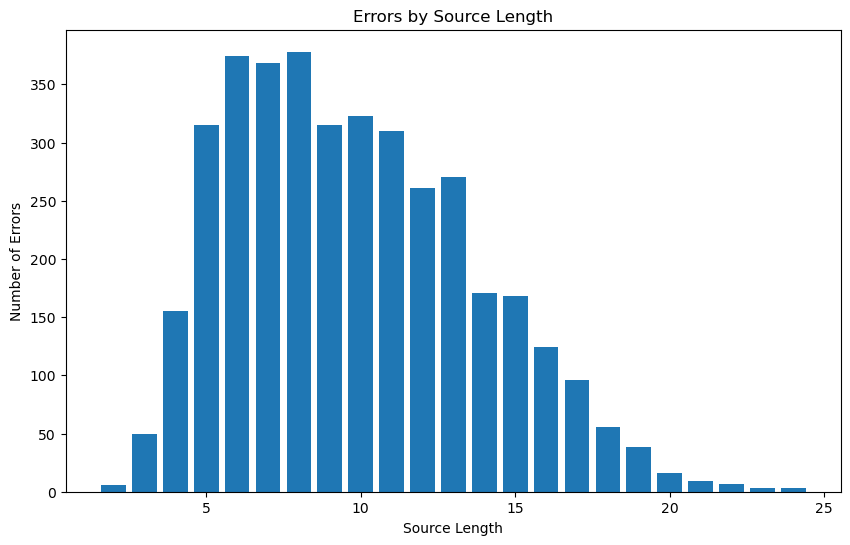

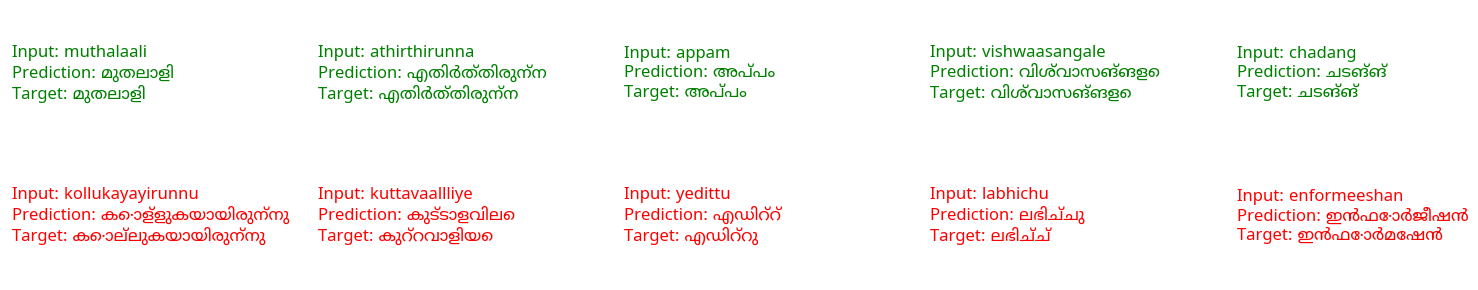

findfont: Font family 'Noto Sans Malayalam' not found.
findfont: Font family 'Noto Sans Malayalam' not found.
findfont: Font family 'Noto Sans Malayalam' not found.
findfont: Font family 'Noto Sans Malayalam' not found.
d:\Anaconda\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 3349 (\N{MALAYALAM LETTER KA}) missing from current font.
  fig.canvas.draw()
d:\Anaconda\Lib\site-packages\seaborn\utils.py:61: UserWarning: Matplotlib currently does not support Malayalam natively.
  fig.canvas.draw()
findfont: Font family 'Noto Sans Malayalam' not found.
d:\Anaconda\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 3376 (\N{MALAYALAM LETTER RA}) missing from current font.
  fig.canvas.draw()
findfont: Font family 'Noto Sans Malayalam' not found.
d:\Anaconda\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 3381 (\N{MALAYALAM LETTER VA}) missing from current font.
  fig.canvas.draw()
findfont: Font family 'Noto Sans Malayalam' not found.
d:\Anaconda\Lib\site-packages

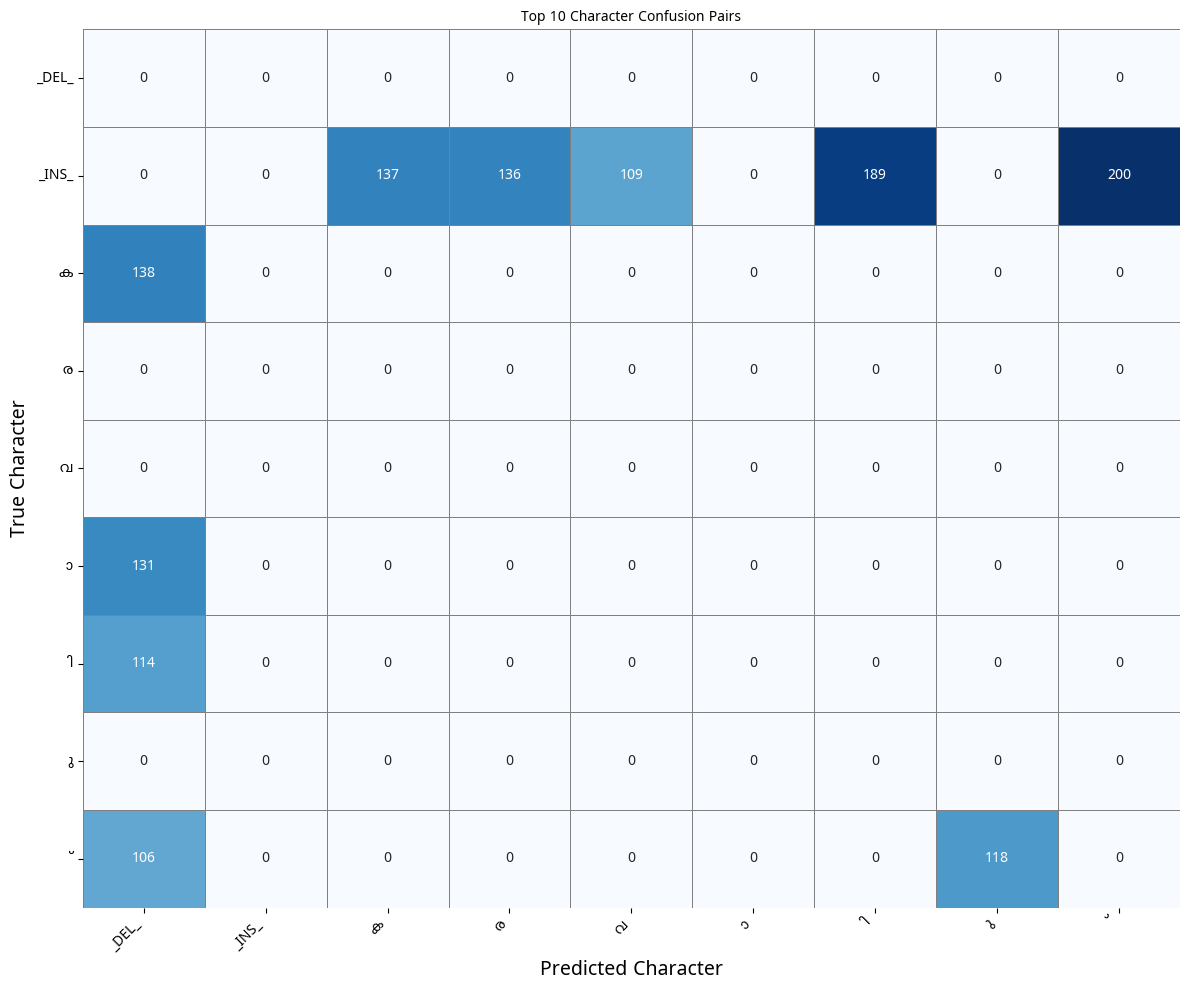

<Figure size 640x480 with 0 Axes>

In [106]:
run_name="test-vanilla-evaluation"

test_with_wandb(run_name=run_name, config=best_config, model_path=best_model_path)